# Multilabel classification using baseline ML models (3x3)

In [3]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import IPython
import joblib
import pickle

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier,LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.svm import SVC
# from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import RandomizedSearchCV

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from scipy.stats import reciprocal, uniform

RANDOM_STATE = 42

import os

import sys 
sys.path.insert(0, "./../" )
from my_classes import ClassificationMetrics

print(os.getcwd())

/home/lieberze/DP/Thesis_public/04_baseline_models


## Tokenizer

In [6]:
suffix = "3x3"
TokenizerAlgorithm = "BLBPE" # else "CharBPE"

if suffix == "3x3":
    CATEGORIES = ['exon', 'intergenic','intron']
elif suffix == "2x2":
    CATEGORIES = ['exon', 'other']
    
ResultsFolder = "Models_and_Results"

In [5]:
RootFolder = "/home/lieberze/DP/Thesis/"

TokenizerFolder = "02_tokenizery_new_data"
if TokenizerAlgorithm == "BLBPE":
    Name = "02_ByteLevelBPE"
elif TokenizerAlgorithm == "CharBPE":
    Name = "01_CharBPE"    
FolderName = "All_genomes_sample"
Length = "All_512"
Size = "5000"
All_512_BLBPE = os.path.abspath(os.path.join(RootFolder, f'{TokenizerFolder}/{Name}/{FolderName}/{Length}/{Size}'))

from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained(All_512_BLBPE)
# tokenizer

file /home/lieberze/DP/Thesis/02_tokenizery_new_data/02_ByteLevelBPE/All_genomes_sample/All_512/5000/config.json not found


## Data

In [6]:
TokenizerName = "BLBPE"

RootFolder = "/home/lieberze/DP/Thesis/"
Baseline = os.path.abspath(os.path.join(RootFolder, "04_baseline"))
DataFolder = os.path.abspath(os.path.join(Baseline, "data"))
TestFolder = os.path.abspath(os.path.join(DataFolder, "test"))
TrainFolder = os.path.abspath(os.path.join(DataFolder, "train"))

if suffix == "3x3":
    TrainFile = os.path.abspath(os.path.join(TrainFolder, "Train_250k.txt"))
    TestFile = os.path.abspath(os.path.join(TestFolder, "Test_holdout_150k.txt"))
elif suffix == "2x2":
    TrainFile = os.path.abspath(os.path.join(TrainFolder, "2x2_train_200k.txt"))
    TestFile = os.path.abspath(os.path.join(TestFolder, "2x2_test_100k.txt"))

In [7]:
# ! head $TrainFile
# print("kontrola vyvazenosti datasetu")
# print("train file:")
# ! cat $TrainFile | cut -f1 | sort | uniq -c
# print("test file:")
# ! cat $TestFile | cut -f1 | sort | uniq -c

## Encode - only once (commented out as it takes a lot of time if accidentally run)

In [8]:
def encode(FileToEncodePath, EncodedFilesPath, Tokenizer):
    with open(FileToEncodePath, "r") as file_in,\
        open(EncodedFilesPath + f"/encoded_{suffix}.txt", "w") as file_out:
        for Line in file_in:
            LineSplit = Line.strip().split()
            SeqType, Seq = LineSplit[0], LineSplit[-1]
            Encoded = Tokenizer.encode(Seq, max_length=128, padding="max_length", truncation=True)
            file_out.write(SeqType + "\t" + str(Encoded) + "\n")
            
# encode(TrainFile, TrainFolder, tokenizer)
# encode(TestFile, TestFolder, tokenizer)

## Load and tokenize, create a dataframe

In [20]:
def LoadData(Path):
    SeqTypes, Ids = [], []
    with open(Path, "r") as file:
        for line in file:
            s, i = line.strip().split("\t")
            i = np.array(i.strip("[]").split(", ")).reshape(-1,1)
            SeqTypes.append(s), Ids.append(i)
            
    # adds 1 (for both algorithms it is the id of the <pad> token, post == at the end
    X = pad_sequences(Ids, value=1, padding='post')
    nsamples, nx, ny = X.shape
    X = X.reshape((nsamples,nx*ny)) # from 3 to 2 dimensions
    y = np.array(SeqTypes)            
    return X, y

def PickBest(BestScores):    
    top_model = sorted(BestScores, key=lambda x: x[0], reverse=True)[0]
    # load model with best params
    validation_score, model, params = top_model
    model.set_params(**params)
    print(model)
    print("validation f1_score (weighted):", validation_score)
    model = model.fit(X_train, y_train)
    return model
      
def FitPredictGetMetrics(model, X_test, y_test, PathToSave, TitleName):
    y_pred = model.predict(X_test)
    
    # metrics 
    # acc_score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
    report = metrics.classification_report(y_test, y_pred, digits=2, output_dict=True, zero_division=0)
    # metrics.plot_confusion_matrix(model, X_test, y_test) 
    
    print("test f1_score (weighted):", f1)
    
    # report table (f1, precision, recall)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_pickle(PathToSave + f"/report_{suffix}.pkl")
    weighted_F1_average = df_report["f1-score"]["weighted avg"]
    print(df_report)
     
    CMName = PathToSave + f'/confusion_matrix_{suffix}.png'
    ClassificationMetrics.ConfMatrix(y_test, y_pred, CATEGORIES, TitleName, CMName)
    return weighted_F1_average

from sklearn import metrics
def ROCAUCcurve(model, X_train, y_train, X_test, y_test, PathToSave, title):
    my_title = f"ROC Curves for {title}"
    plt.figure(figsize=[8,6])
    sns.set(font_scale=1.3)       
    if suffix == "2x2":
        pos_label = "exon"
        model.fit(X_train, y_train)
        y = np.array(y_test)
        try:
            pred = model.predict_proba(X_test)[:,0]
        except:
            pred = clf.decision_function(X_test)
            pred = [1-x for x in pred]
            
        fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=pos_label)
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                           estimator_name=my_title)
        # display.plot()
        plt.title(my_title)
        auc = round(np.trapz(tpr,fpr),2)
        plt.plot(fpr,tpr,label=f"ROC of class {pos_label}, AUC = "+str(auc))
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dotted')
        plt.legend(loc=4)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.xlim([-0.01,1.0])
        plt.ylim([0.00,1.01])
        plt.savefig(PathToSave + f'/ROC_curve_{suffix}.png')
        plt.show()
    else:
        visualizer = ROCAUC(model, classes=CATEGORIES, title=my_title, micro=False, macro=False)
        visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
        visualizer.score(X_test, y_test)        # Evaluate the model on the test data
        visualizer.show(outpath = PathToSave + f'/ROC_curve_{suffix}.png')

## Grid of hyperparameters for each model

In [4]:
model_grid = {    
    # https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
    RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE): {
            "n_estimators": [150, 200, 400],
            "max_depth": [1, 3, 5, 7, 9],
            "criterion": ["gini", "entropy"],
            "min_samples_split": [0.6, 0.8, 2, 4],
            "min_samples_leaf": [0.4, 1, 2, 4, 10, 15]
        },    
    # https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
    GradientBoostingClassifier(max_features = 'sqrt', subsample = 0.8, random_state=RANDOM_STATE): {
            "min_samples_split": [3000, 4000, 5000, 6000],
            "min_samples_leaf": [50, 100, 150, 200],
            "max_depth": [5, 6, 7, 8]
        },        
    RidgeClassifier(random_state=RANDOM_STATE): {
            "alpha": [1e-3, 1e-2, 1e-1, 1]
            },    
    # https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa
    MLPClassifier(random_state=RANDOM_STATE, max_iter=300): { # trenuje se dlouho (?)
            'hidden_layer_sizes': [(100,50), (100,50, 100), (100,100,1000), (100,), (200,)], # uzpusobit velikosti vstupniho vektoru
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.001, 0.005, 0.05],
            'learning_rate': ['constant','adaptive'],
            'early_stopping': [True, False],
    },
    LogisticRegression(random_state=RANDOM_STATE): {
        'penalty' : ['none', 'l1', 'l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'C' : [100, 10, 1.0, 0.1, 0.01],
    },
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    # https://stats.stackexchange.com/questions/243908/tuning-order-xgboost/386794#386794
    XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, n_estimators=100): { # Lower the learning rate and decide the optimal parameters
        "booster": ["gbtree"],# , "gblinear","dart"],
        "learning_rate": [0.3, 0.1, 0.01, 0.05], # Choose a relatively high learning rate
        "max_depth": [5, 6, 8, 10], # Tune tree-specific parameters (max_depth, min_child_weight, gamma, subsample, colsample_bytree)
                        # This should be between 3-10
        "gamma" :  [0, 0.1, 0.2],
        "colsample_bytree": [0.4, 0.5, 0.6, 0.7],
        'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0, 12.0],
        "subsample" : [0.6, 0.7, 0.9],
        "reg_lambda": [0.05, 0.1, 1.0], # Tune regularization parameters (lambda, alpha)        
    }
#     SVC(random_state=RANDOM_STATE): { # bezi extremne dlouho
#         "kernel":['linear', 'rbf', 'poly'],
#         "gamma": reciprocal(0.001, 0.1),
#         "C": uniform(1, 10),
#         "degree": [0, 1, 2, 3, 4, 5, 6]
#     }
}

In [11]:
def TryClassifier(model, grid, X_train, y_train):
    kf = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
    model = RandomizedSearchCV(estimator=model, 
                               param_distributions=grid,
                               n_iter=5, 
                               cv=kf,
                               verbose=1, 
                               n_jobs=-1,
                               random_state=RANDOM_STATE, 
                               scoring = ["f1_weighted", "accuracy", "precision_weighted", "recall_weighted"], # acc, recall, precision
                               refit = "f1_weighted", # has to be set to the metric according to which the best params fit
                               return_train_score=True
                              )
    model.fit(X_train, y_train)  
    # return also mean, std
    # best_score = model.best_score_ 
    # best_index = model.best_index_
    # best_params = model.best_estimator_.get_params()
    # BestScore = {"best_score": best_score, "best_score": best_params, "best_score": best_index}
    return model.best_estimator_, model

In [14]:
# Load Data
X_train, y_train = LoadData(TrainFolder + f"/{TokenizerName}/encoded_{suffix}.txt")
X_test, y_test = LoadData(TestFolder + f"/{TokenizerName}/encoded_{suffix}.txt")

if suffix == "2x2": # only for binary classification
    subs = {
            "exon": "exon", 
            "intron": "other",
            "intergenic": "other"
            }
    y_train = [subs.get(item) for item in y_train]
    y_test = [subs.get(item) for item in y_test]

## Predict and create CM, ROC and reports

The following code is a bit chaotic as I had to generate some graphs again without the need to retraining the models (which was time consuming)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
test f1_score (weighted): 0.34229258818074565
              precision    recall  f1-score       support
exon           0.380830  0.746731  0.504412   33340.00000
intergenic     0.422905  0.317511  0.362707   33413.00000
intron         0.356986  0.102445  0.159204   33247.00000
accuracy       0.389110  0.389110  0.389110       0.38911
macro avg      0.386907  0.388896  0.342107  100000.00000
weighted avg   0.386961  0.389110  0.342293  100000.00000


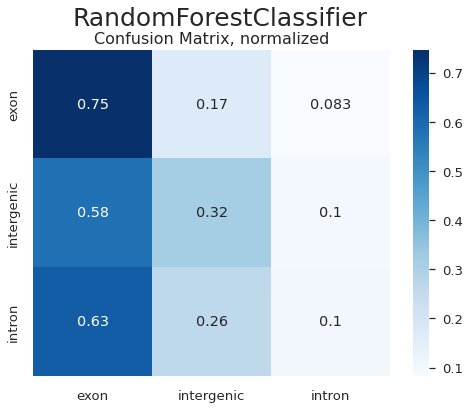

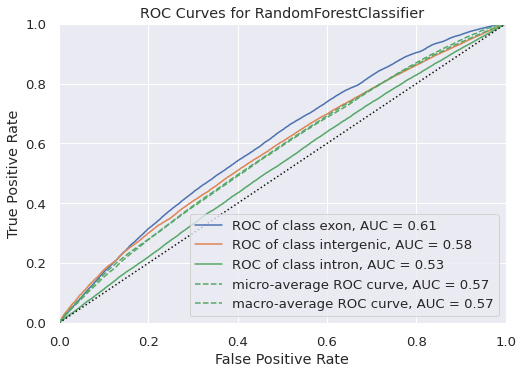

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [ ]:
%%time
for model, grid in model_grid.items():
    ModelFolderName = str(model).split("(")[0]    
    BestEstimator, Model = TryClassifier(model, grid, X_train, y_train)
    
    # save files to:
    Path = f"./{ResultsFolder}/{TokenizerAlgorithm}/{ModelFolderName}"
    
    # create a folder if it doesn't already exist
    !mkdir -p {Path}
    
    # save best model
    filename = f'/classification_model_{suffix}.sav'
    joblib.dump(BestEstimator, Path + filename)
    
    # save whole model with cv scores
    with open(f"{Path}/ModelScores_{suffix}.pk", 'wb') as f:
        pickle.dump(Model, f)
        
    # results and confusion matrix
    sns.set(font_scale=1.2)    
    FitPredictGetMetrics(BestEstimator, X_test, y_test, Path, ModelFolderName)
    
    # ROC curve
    sns.set(font_scale=1.2)    
    ROCAUCcurve(BestEstimator, X_train, y_train, X_test, y_test, Path)           

## Cross Validation results:

In [12]:
dataframe = {}
for model, grid in model_grid.items():
    ModelFolderName = str(model).split("(")[0] 
    Path = f"./{ResultsFolder}/{TokenizerAlgorithm}/{ModelFolderName}"
    with open(f"{Path}/ModelScores_{suffix}.pk", 'rb') as f:
        Model = pickle.load(f)
    d = [ ['mean_test_accuracy','std_test_f1_weighted'],
        ['mean_test_precision_weighted','std_test_f1_weighted'],
        ['mean_test_recall_weighted','std_test_f1_weighted'],
         ['mean_test_f1_weighted','std_test_f1_weighted']]
    df_row = {}
    for metric_names in d:
        mean, std = metric_names
        row_name = " ".join(mean.split("_")[1:])
        mean = round(Model.cv_results_[mean][Model.best_index_], 3)
        std = round(Model.cv_results_[std][Model.best_index_], 3)
        # print(ModelFolderName)
        # print("\t",row_name, ":", mean, u"\u00B1", std)
        df_row[row_name] = f"{mean} \u00B1 {std}"
    dataframe[ModelFolderName] = df_row
    
dataframe = pd.DataFrame.from_dict(dataframe,orient='index')
dataframe.to_csv(f"{ResultsFolder}/{TokenizerAlgorithm}/test_metrics_{suffix}.csv")
dataframe.to_excel(f"{ResultsFolder}/{TokenizerAlgorithm}/test_metrics_{suffix}.xlsx")  

dataframe

,test accuracy,test precision weighted,test recall weighted,test f1 weighted
RandomForestClassifier,0.388 ± 0.003,0.387 ± 0.003,0.388 ± 0.003,0.339 ± 0.003
GradientBoostingClassifier,0.434 ± 0.003,0.424 ± 0.003,0.434 ± 0.003,0.416 ± 0.003
RidgeClassifier,0.402 ± 0.004,0.388 ± 0.004,0.402 ± 0.004,0.361 ± 0.004
MLPClassifier,0.358 ± 0.021,0.333 ± 0.021,0.358 ± 0.021,0.291 ± 0.021
LogisticRegression,0.371 ± 0.003,0.367 ± 0.003,0.371 ± 0.003,0.344 ± 0.003
XGBClassifier,0.439 ± 0.004,0.43 ± 0.004,0.439 ± 0.004,0.418 ± 0.004


## Make ROC curves (one more time and better)

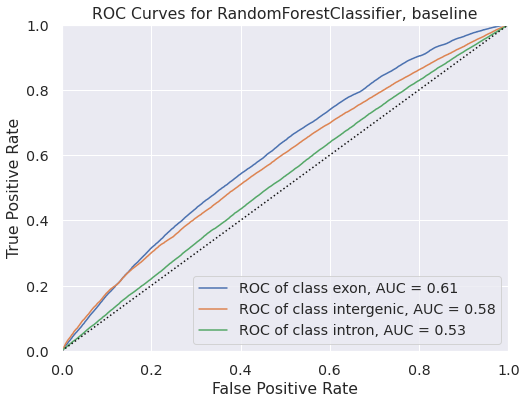

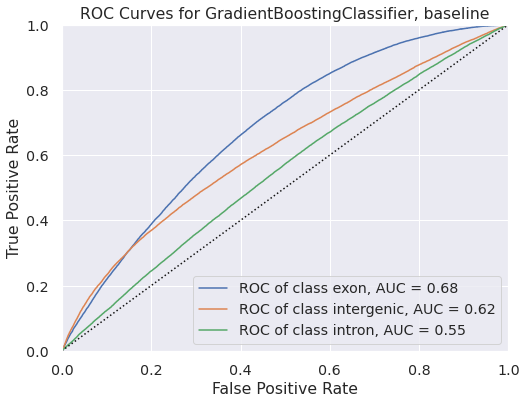

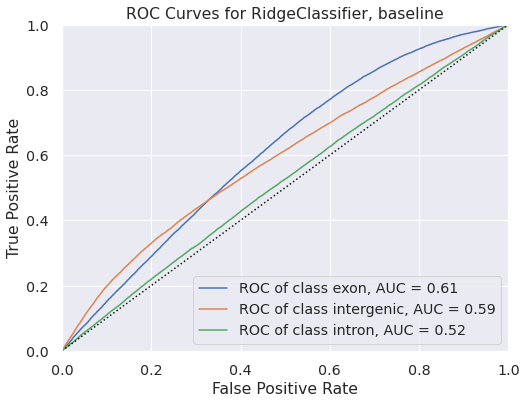

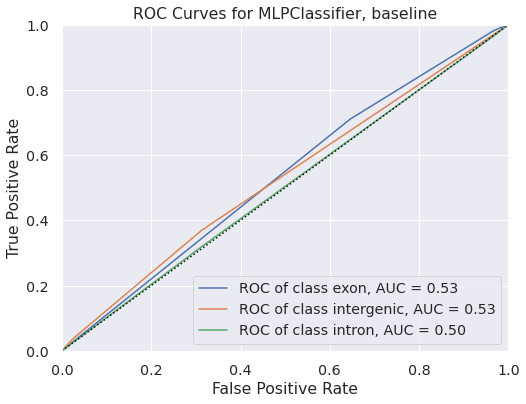

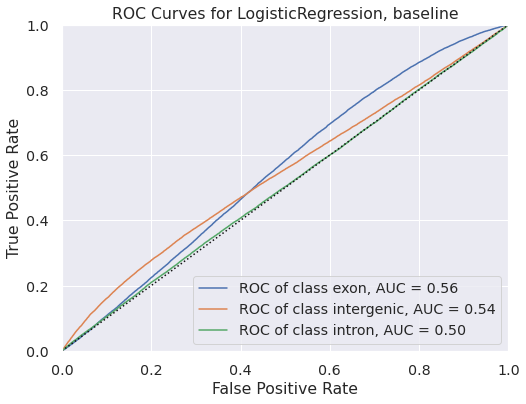

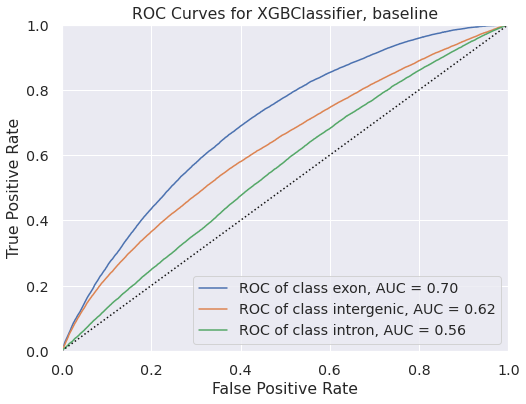

In [21]:
for model in model_grid.keys():
    ModelFolderName = str(model).split("(")[0]   
    Path = f"./{ResultsFolder}/{TokenizerAlgorithm}/{ModelFolderName}"
    clf = joblib.load(f"{Path}/classification_model_{suffix}.sav")
    PathToSave = Path
    title = f"{ModelFolderName}, baseline"
    ROCAUCcurve(clf, X_train, y_train, X_test, y_test, PathToSave, title)

# Load the confusion matrices

RandomForestClassifier 0.34


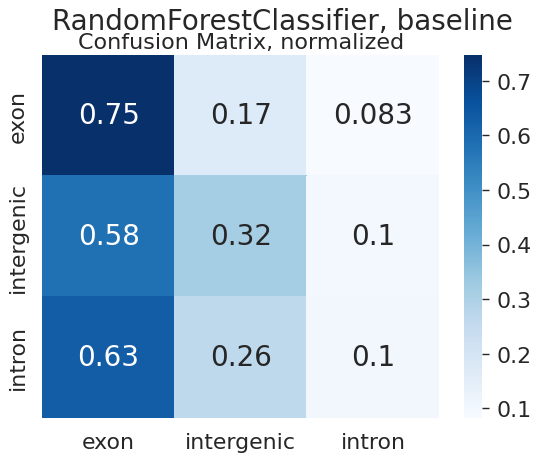

GradientBoostingClassifier 0.42


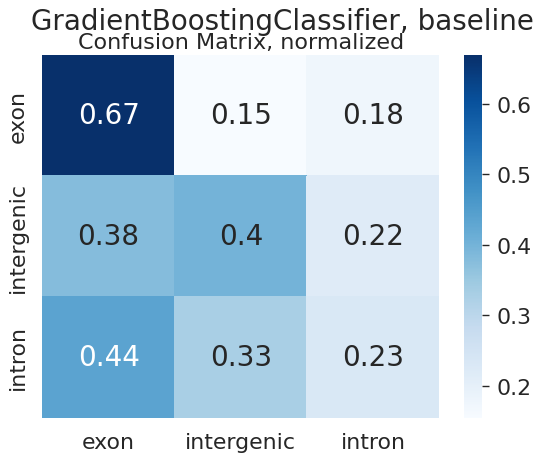

RidgeClassifier 0.36


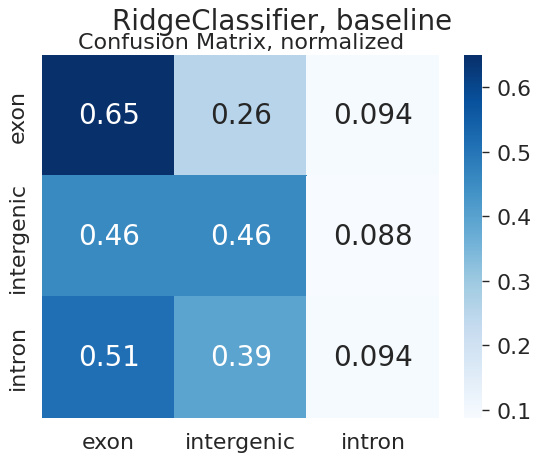

MLPClassifier 0.28


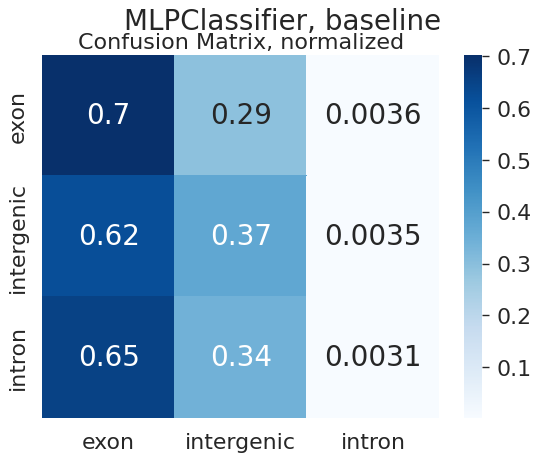

LogisticRegression 0.34


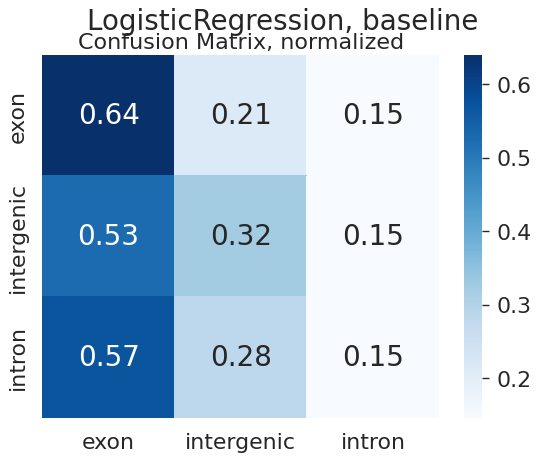

XGBClassifier 0.42


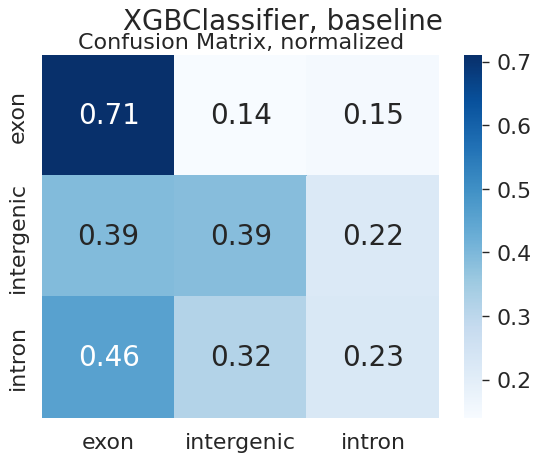

In [8]:
from PIL import Image
for model in model_grid.keys():
    ModelFolderName = str(model).split("(")[0]   
    Path = f"./{ResultsFolder}/{TokenizerAlgorithm}/{ModelFolderName}"
    with open(Path + f'/report_{suffix}.pkl', 'rb') as f:
        report = pickle.load(f)
    # print(report)
    print(ModelFolderName, round(report["f1-score"]["weighted avg"],2))
     
    conf_m = Image.open(Path + f'/confusion_matrix_{suffix}.png')
    # roc = Image.open(Path + '/ROC_curve_3x3.png')
    
    conf_m.show()
    # roc.show() 

## Save reports as excel (xlsx) file

In [22]:
reports = []
for model, grid in model_grid.items():
    ModelFolderName = str(model).split("(")[0]    
    
    # save files to:
    Path = f"{Baseline}/{ResultsFolder}/{TokenizerAlgorithm}/{ModelFolderName}"
    
    df_report = pd.read_pickle(Path + f"/report_{suffix}.pkl")
    df_report["model"] = ModelFolderName
    reports.append(df_report)
dfs = [df for df in reports]
df = pd.concat(dfs, axis=0)
df.to_excel(f"{Baseline}/reports_{suffix}.xlsx")